# 5. FastText (entrenamiento local con GPU/CPU)


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import fasttext, os, sys

In [3]:
import pandas as pd, numpy as np, random
from sklearn.model_selection import train_test_split

PROJECT_DIR = r"C:\Users\elias\OneDrive\Desktop\MachineLearning\JBOOKS\Project3DL2"
DATA_PATH   = rf"{PROJECT_DIR}\jarvis-calling-hiring-contest\Resume\Resume.csv"

TEXT_COL  = "Resume_str"
LABEL_COL = "Category"
SEED = 42
random.seed(SEED); np.random.seed(SEED)

try:
    train_df, val_df, test_df  # si ya existen, se respetan
except NameError:
    df = pd.read_csv(DATA_PATH).dropna(subset=[TEXT_COL, LABEL_COL]).reset_index(drop=True)
    train_df, temp_df = train_test_split(df, test_size=0.20, random_state=SEED, stratify=df[LABEL_COL])
    val_df,   test_df = train_test_split(temp_df, test_size=0.50, random_state=SEED, stratify=temp_df[LABEL_COL])

all_labels = sorted(train_df[LABEL_COL].unique())
label2id = {c:i for i,c in enumerate(all_labels)}
id2label = {i:c for c,i in label2id.items()}
NUM_CLASSES = len(all_labels)
print("train/val/test:", train_df.shape, val_df.shape, test_df.shape, "| NUM_CLASSES:", NUM_CLASSES)



train/val/test: (1987, 4) (248, 4) (249, 4) | NUM_CLASSES: 24


In [4]:
import re, unicodedata

HEADERS = {
    "objective","summary","professional summary","career objective","profile",
    "experience","work experience","employment history","skills","technical skills",
    "education","certifications","projects","accomplishments","responsibilities",
    "references","achievements"
}

def normalize_tech_tokens(s: str) -> str:
    s = s.replace("C++", " cpp ").replace("c++", " cpp ")
    s = re.sub(r"\bC#\b", " csharp ", s, flags=re.I)
    s = re.sub(r"\.NET\b", " dotnet ", s, flags=re.I)
    s = re.sub(r"\bNode\.js\b", " nodejs ", s, flags=re.I)
    s = re.sub(r"\bReact\.js\b", " reactjs ", s, flags=re.I)
    s = re.sub(r"\bExpress\.js\b", " expressjs ", s, flags=re.I)
    s = re.sub(r"\bAngular\.js\b", " angularjs ", s, flags=re.I)
    s = re.sub(r"\bASP\.NET\b", " aspnet ", s, flags=re.I)
    return s

def drop_resume_headers(text: str) -> str:
    keep = []
    for ln in str(text).splitlines():
        t = unicodedata.normalize("NFKC", ln).strip().lower()
        t = re.sub(r"[:\-•]+$", "", t).strip()
        if t in HEADERS or len(t) <= 2:
            continue
        keep.append(ln)
    return "\n".join(keep)

def clean_text_ft(s: str) -> str:
    s = unicodedata.normalize("NFKC", str(s))
    s = drop_resume_headers(s)
    s = normalize_tech_tokens(s)
    s = s.lower()
    s = re.sub(r"[^\w\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def slugify_label(lbl: str) -> str:
    s = unicodedata.normalize("NFKC", str(lbl)).lower()
    s = re.sub(r"[^a-z0-9]+", "_", s).strip("_")
    return s or "cls"

label_to_ft = {lbl: f"__label__{slugify_label(lbl)}" for lbl in all_labels}
ft_to_label = {v: k for k, v in label_to_ft.items()}
print("Ejemplo mapping:", list(label_to_ft.items())[:5])


Ejemplo mapping: [('ACCOUNTANT', '__label__accountant'), ('ADVOCATE', '__label__advocate'), ('AGRICULTURE', '__label__agriculture'), ('APPAREL', '__label__apparel'), ('ARTS', '__label__arts')]


## Oversampling

In [5]:
from collections import Counter
import io, os, pandas as pd

def to_ft_lines_clean(df, text_col, label_col, label_to_ft):
    lines=[]
    for text,lbl in zip(df[text_col].astype(str), df[label_col].astype(str)):
        t = clean_text_ft(text)
        y = label_to_ft[lbl]
        lines.append(f"{y} {t}")
    return lines

# Subir piso de ejemplos por clase en TRAIN (no toques test)
cnt = train_df["Category"].value_counts().sort_values(ascending=True)
TARGET_MIN = max(150, int(cnt.quantile(0.75)))  # p75 o 150, lo que sea mayor
print("TARGET_MIN por clase:", TARGET_MIN)

df_tr = train_df[["Resume_str","Category"]].copy()
aug = []
for cls, n in cnt.items():
    if n < TARGET_MIN and n>0:
        need = TARGET_MIN - n
        pool = df_tr[df_tr["Category"]==cls]
        extra = pool.sample(n=need, replace=True, random_state=42)
        aug.append(extra)
df_tr_bal = pd.concat([df_tr]+aug, axis=0, ignore_index=True).sample(frac=1.0, random_state=42)
print("Nueva dist (aprox):\n", df_tr_bal["Category"].value_counts().sort_values())


# Líneas para FastText (train balanceado + val original; y también trainval para el final)
train_lines_bal = to_ft_lines_clean(df_tr_bal, TEXT_COL, LABEL_COL, label_to_ft)
val_lines       = to_ft_lines_clean(val_df,   TEXT_COL, LABEL_COL, label_to_ft)
trainval_lines  = train_lines_bal + val_lines

FT_DIR = "./fasttext_data_bal"
os.makedirs(FT_DIR, exist_ok=True)
train_path    = os.path.join(FT_DIR, "train.txt")
val_path      = os.path.join(FT_DIR, "val.txt")
trainval_path = os.path.join(FT_DIR, "trainval.txt")

with io.open(train_path, "w", encoding="utf-8") as f: f.write("\n".join(train_lines_bal))
with io.open(val_path, "w", encoding="utf-8") as f:   f.write("\n".join(val_lines))
with io.open(trainval_path, "w", encoding="utf-8") as f: f.write("\n".join(trainval_lines))

print("Guardado:", train_path, val_path, trainval_path)
print("Nueva distribución aprox (train balanceado):")
print(df_tr_bal[LABEL_COL].value_counts().sort_values())


TARGET_MIN por clase: 150
Nueva dist (aprox):
 Category
ADVOCATE                  150
CONSTRUCTION              150
BUSINESS-DEVELOPMENT      150
BANKING                   150
ACCOUNTANT                150
DESIGNER                  150
AGRICULTURE               150
FITNESS                   150
SALES                     150
AVIATION                  150
DIGITAL-MEDIA             150
HR                        150
HEALTHCARE                150
TEACHER                   150
CHEF                      150
FINANCE                   150
PUBLIC-RELATIONS          150
APPAREL                   150
BPO                       150
AUTOMOBILE                150
ARTS                      150
CONSULTANT                150
INFORMATION-TECHNOLOGY    150
ENGINEERING               150
Name: count, dtype: int64
Guardado: ./fasttext_data_bal\train.txt ./fasttext_data_bal\val.txt ./fasttext_data_bal\trainval.txt
Nueva distribución aprox (train balanceado):
Category
ADVOCATE                  150
CONSTRUCTION 

## Entrenamiento

In [6]:
import fasttext, os
os.environ["OMP_NUM_THREADS"] = str(os.cpu_count())  # asegurar hilos

def train_ft(input_path, *, lr=0.5, epoch=50, dim=300, wordNgrams=3, minn=2, maxn=5,
             bucket=5_000_000, loss="ova"):
    """
    Preset:
      - wordNgrams=3 y subword (minn/maxn) → mejor recall y OOV
      - loss='ova' → macro-F1 más alto en desbalance
      - bucket grande → más n-gram features
    """
    return fasttext.train_supervised(
        input=input_path,
        lr=lr, epoch=epoch, dim=dim,
        wordNgrams=wordNgrams,
        minn=minn, maxn=maxn,
        bucket=bucket,
        loss=loss,
        thread=os.cpu_count(),
        verbose=2
    )

# Entrena sobre train+val balanceado
ft_final = train_ft(trainval_path)
print("Modelo entrenado.")


Modelo entrenado.


## Metricas

In [7]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import numpy as np

def ft_predict_labels(model, texts, k=1):
    labels, probs = model.predict(texts, k=k)
    top1 = [ft_to_label.get(l[0], "__UNK__") if len(l)>0 else "__UNK__" for l in labels]
    return top1, labels, probs

# Predicción top-1
test_texts_clean = [clean_text_ft(t) for t in test_df[TEXT_COL].astype(str)]
y_test_true = test_df[LABEL_COL].astype(str).tolist()

y_pred_lbl, _, _ = ft_predict_labels(ft_final, test_texts_clean, k=1)

# Normaliza por si acaso y mapea a IDs
norm = lambda s: " ".join(str(s).split()).strip()
y_true_norm = [norm(x) for x in y_test_true]
y_pred_norm = [norm(x) for x in y_pred_lbl]

y_true_id = np.array([label2id[x] for x in y_true_norm])
y_pred_id = np.array([label2id.get(x, -1) for x in y_pred_norm])
mask = y_pred_id != -1
y_true_id = y_true_id[mask]; y_pred_id = y_pred_id[mask]

acc = accuracy_score(y_true_id, y_pred_id)
prec_m, rec_m, f1_m, _ = precision_recall_fscore_support(y_true_id, y_pred_id, average="macro", zero_division=0)
prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(y_true_id, y_pred_id, average="weighted", zero_division=0)
print({"test_accuracy":acc, "test_precision_macro":prec_m, "test_recall_macro":rec_m, "test_f1_macro":f1_m,
       "test_precision_weighted":prec_w, "test_recall_weighted":rec_w, "test_f1_weighted":f1_w})

print("\nReporte por clase (test):")
print(classification_report(y_true_id, y_pred_id, target_names=[id2label[i] for i in range(NUM_CLASSES)], digits=4))


{'test_accuracy': 0.5220883534136547, 'test_precision_macro': 0.5132000063564709, 'test_recall_macro': 0.4989267676767677, 'test_f1_macro': 0.4737797239462891, 'test_precision_weighted': 0.5495825151610765, 'test_recall_weighted': 0.5220883534136547, 'test_f1_weighted': 0.5049988842723464}

Reporte por clase (test):
                        precision    recall  f1-score   support

            ACCOUNTANT     0.6667    0.8333    0.7407        12
              ADVOCATE     0.5000    0.2500    0.3333        12
           AGRICULTURE     0.4000    0.3333    0.3636         6
               APPAREL     0.5000    0.2222    0.3077         9
                  ARTS     0.0000    0.0000    0.0000        11
            AUTOMOBILE     0.1667    0.6667    0.2667         3
              AVIATION     0.5000    0.5000    0.5000        12
               BANKING     0.7500    0.2500    0.3750        12
                   BPO     0.0000    0.0000    0.0000         2
  BUSINESS-DEVELOPMENT     0.4348    0.83

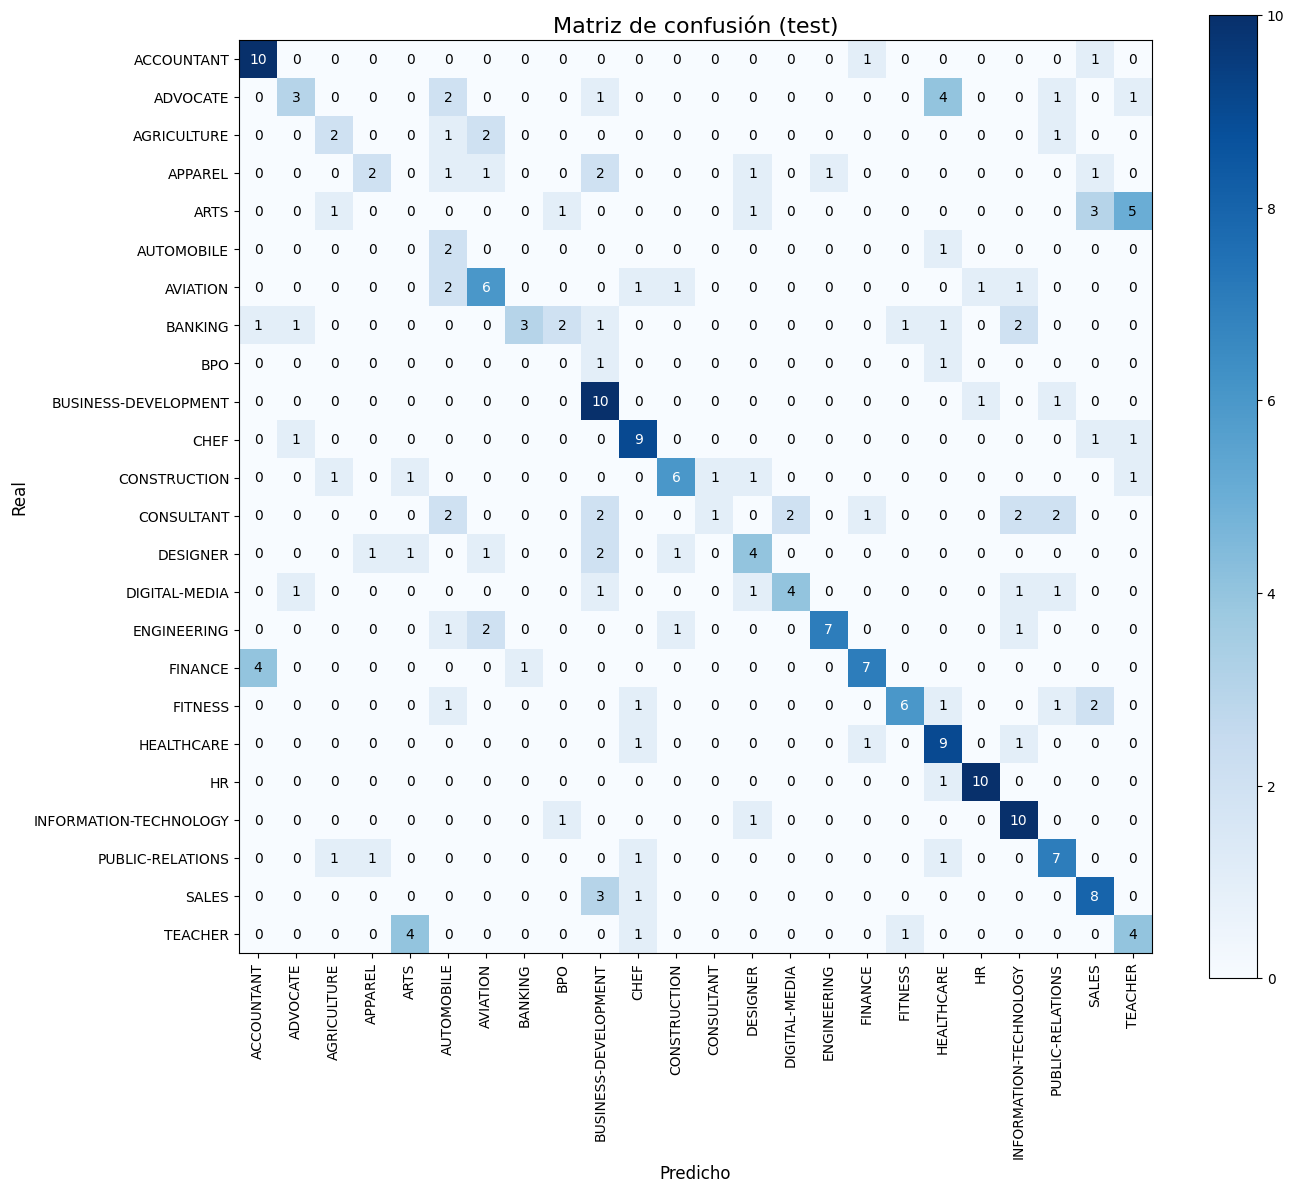

In [8]:
# Matriz de confusión con figura más grande y anotaciones
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_test_true, y_pred_lbl)

fig, ax = plt.subplots(figsize=(14, 12))  # ajustar tamaño aquí
im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
cbar = ax.figure.colorbar(im, ax=ax)
ax.set_title("Matriz de confusión (test)", fontsize=16)
ticks = np.arange(len(id2label))
labels = [id2label[i] for i in ticks]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels, rotation=90, fontsize=10)
ax.set_yticklabels(labels, fontsize=10)
ax.set_xlabel("Predicho", fontsize=12)
ax.set_ylabel("Real", fontsize=12)

# Añadir los números en cada celda
fmt = "d"
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black", fontsize=10)

plt.tight_layout()
plt.show()


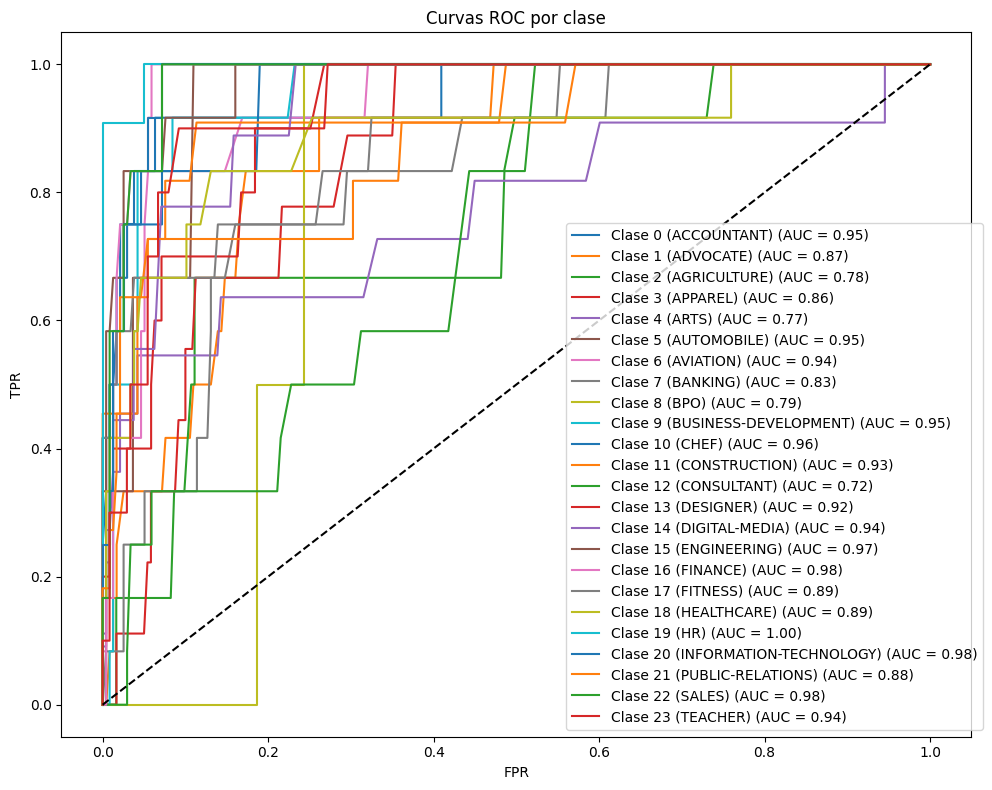

In [9]:
# 8. Curva ROC
# Import only the missing utilities
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Build y_prob (probabilities per class) and y_true (integer class ids) from existing variables.
# We use the trained fasttext model `ft_final`, the cleaned test texts `test_texts_clean`,
# and the mappings `ft_to_label` and `label2id` that exist in the notebook.
#
# fastText can return the top-K labels/probs per sample; request K=NUM_CLASSES so we get
# a probability for every class (if not present, probability stays 0).
labels_all, probs_all = ft_final.predict(test_texts_clean, k=NUM_CLASSES)

# Create probability matrix: shape (n_samples, NUM_CLASSES)
y_prob = np.zeros((len(test_texts_clean), NUM_CLASSES), dtype=float)
for i, (labs, ps) in enumerate(zip(labels_all, probs_all)):
    for lab, p in zip(labs, ps):
        lbl_name = ft_to_label.get(lab, "__UNK__")
        idx = label2id.get(lbl_name)
        if idx is not None:
            y_prob[i, idx] = p

# Use the already computed integer true labels
y_true = y_true_id

# Binarize true labels for roc_curve per class
labels_bin = label_binarize(y_true, classes=np.arange(NUM_CLASSES))

probs = y_prob  # keep same variable name used below

plt.figure(figsize=(10, 8))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(labels_bin[:, i], probs[:, i])
    plt.plot(fpr, tpr, label=f'Clase {i} ({id2label.get(i,"")}) (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curvas ROC por clase')
plt.legend(loc='lower right', bbox_to_anchor=(1.02, 0))
plt.tight_layout()
plt.show()